In [7]:
import time
import math, os

from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor

from hist import Hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import matplotlib.pyplot as plt
from plotter import create_plot1d, create_plot2d, acceptance_plot

In [21]:
d0_cols = ['D0_pt', 'D0_eta', 'D0_phi', 'D0_rap', 'D0_mass12', 'D0_mass21', 'D0_vtxIdx', 'D0_chi2', 'D0_dl', 'D0_dlErr', 'D0_dlSig',
           'D0_cosphi', 'D0_x', 'D0_y', 'D0_z', 'D0_hasMuon',
           'D0_t1pt', 'D0_t1eta', 'D0_t1phi', 'D0_t1chindof', 'D0_t1nValid', 'D0_t1nPix', 'D0_t1dxy', 'D0_t1dz', 'D0_t1chg', 
           'D0_t2pt', 'D0_t2eta', 'D0_t2phi', 'D0_t2chindof', 'D0_t2nValid', 'D0_t2nPix', 'D0_t2dxy', 'D0_t2dz', 'D0_t2chg',]

dstar_cols = ['Dstar_pt', 'Dstar_eta', 'Dstar_phi', 'Dstar_rap', 'Dstar_deltam', 'Dstar_deltamr', 'Dstar_vtxIdx', 'Dstar_hasMuon',
              'Dstar_D0pt', 'Dstar_D0eta', 'Dstar_D0phi', 'Dstar_D0mass', 'Dstar_D0chi2', 'Dstar_D0dl', 'Dstar_D0dlxy', 'Dstar_D0dlErr',
              'Dstar_D0dlSig', 'Dstar_D0cosphi', 'Dstar_D0x', 'Dstar_D0y', 'Dstar_D0z',
              'Dstar_Kpt', 'Dstar_Keta', 'Dstar_Kphi', 'Dstar_KvtxIdx', 'Dstar_Kchindof', 'Dstar_KnValid', 'Dstar_KnPix', 'Dstar_Kdxy',
              'Dstar_Kdz', 'Dstar_Kchg',
              'Dstar_pipt', 'Dstar_pieta', 'Dstar_piphi', 'Dstar_pivtxIdx', 'Dstar_pichindof', 'Dstar_pinValid', 'Dstar_pinPix',
              'Dstar_pidxy', 'Dstar_pidz', 'Dstar_pichg',
              'Dstar_pispt', 'Dstar_piseta', 'Dstar_pisphi', 'Dstar_pisvtxIdx', 'Dstar_pischindof', 'Dstar_pisnValid', 'Dstar_pisnPix',
              'Dstar_pisdxy', 'Dstar_pisdz', 'Dstar_simIdx', 'Dstar_D0simIdx', 'Dstar_D0recIdx']

gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

D0_PDG_MASS = 1.864

def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        col = c[c.find("_")+1:]
        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

def make_acceptance_plot(fig, hist_reco, hist_gen):
    fig.clear()
    ax = fig.add_subplot()
    acceptance_plot(hist_reco, hist_gen, ax=ax)
    ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
    ax.set_ylabel(r"$\eta_{D^{*}}$")

def fill_hists(hists, candidate, get_deltam=False):
    hists['pt'].fill(pt=ak.flatten(candidate.pt))
    hists['eta'].fill(eta=ak.flatten(candidate.eta))
    hists['phi'].fill(phi=ak.flatten(candidate.phi))
    if get_deltam:
        hists['deltam'].fill(deltam=ak.flatten(candidate.deltamr))
    else:
        hists['mass'].fill(mass=ak.flatten(candidate.mass))
    hists['ptxeta'].fill(
        pt=ak.flatten(candidate.pt),
        eta=ak.flatten(candidate.eta)
        )
    hists['ptxmodeta_0-10'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )
    hists['ptxmodeta_0-100'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )
    hists['ptxmodeta_var'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )

def build_4mom_string(candidate):
    return f'({candidate.pt:.2f}, {candidate.eta:.2f}, {candidate.phi:.2f}, {candidate.mass:.2f})'

def to_cartesian(cand):
    x = cand.pt*math.cos(cand.phi)
    y = cand.pt*math.sin(cand.phi)
    z = cand.pt*math.sinh(cand.eta)
    t = math.sqrt(x*x + y*y + z*z + cand.mass*cand.mass)

    return t, x, y, z

def sum_cand(cand1, cand2):
    t1, x1, y1, z1 = to_cartesian(cand1)
    t2, x2, y2, z2 = to_cartesian(cand2)

    tr = t1+t2
    xr = x1+x2
    yr = y1+y2
    zr = z1+z2

    r = math.sqrt(xr*xr + yr*yr + zr*zr)
    pt = math.sqrt(xr*xr + yr*yr)
    eta = math.asinh(zr / r)
    phi = math.atan2(yr, xr)
    mass = math.sqrt(tr*tr - xr*xr - yr*yr - zr*zr)

    return f'({pt:.2f},{eta:.2f},{phi:.2f},{mass:.2f})'


def print_candidate(candidate):
    quadrimom = build_4mom_string(candidate)
    print(f"PDGId: {candidate.pdgId}, motherId: {candidate.genPartIdxMother}, n_daughters: {candidate.numberOfDaughters}, status: {candidate.status}, 4-momentum (pt, eta, phi, mass): {quadrimom}")

In [18]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

paths = [
    '/Users/kevimota/cernbox/DstarPtGun/220110_124229/0000',
    '/Users/kevimota/cernbox/DstarPtGun/220110_124229/0001',
    ]

files = []
for path in paths:
    with os.scandir(path) as it:
        for file in it:
            if file.name.endswith('.root') and (file.stat().st_size != 0):
                files.append(file.path)

In [19]:
class AcceptanceProcessor(processor.ProcessorABC):
    def __init__(self):
        Gen_Dstar_hists = {
            'pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Gen D^*}$ [GeV]").Double(),
            'eta': Hist.new.Regular(60, -4, 4, name="eta", label=r"$\eta_{Gen D^*}$").Double(),
            'phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Gen D^*}$").Double(),
            'deltam': Hist.new.Regular(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{Gen D^*}$ [GeV]").Double(),
            'ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Gen D^*}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Gen D^*}$")
                .Double()
                ),
            'ptxmodeta_0-10': (
                Hist.new
                .Variable(range(11), name='pt', label=r"$p_{T,Gen D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^*}|$")
                .Double()
                ),
            'ptxmodeta_0-100': (
                Hist.new
                .Variable(range(0,101,10), name='pt', label=r"$p_{T,Gen D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^*}|$")
                .Double()
                ),
            'ptxmodeta_var': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Gen D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^*}|$")
                .Double()
                ),
        }

        Gen_D0_hists = {
            'pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Gen D_0}$ [GeV]").Double(),
            'eta': Hist.new.Regular(60, -5, 5, name="eta", label=r"$\eta_{Gen D_0}$").Double(),
            'phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Gen D_0}$").Double(),
            'mass': Hist.new.Regular(100, 1.7, 2.0, name="mass", label=r"$m_{Gen D_0}$ [GeV]").Double(),
            'ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Gen D^0}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Gen D^0}$")
                .Double()
                ),
            'ptxmodeta_0-10': (
                Hist.new
                .Variable(range(11), name='pt', label=r"$p_{T,Gen D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^0}|$")
                .Double()
                ),
            'ptxmodeta_0-100': (
                Hist.new
                .Variable(range(0,101,10), name='pt', label=r"$p_{T,Gen D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^0}|$")
                .Double()
                ),
            'ptxmodeta_var': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Gen D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen D^0}|$")
                .Double()
                ),
        }

        Reco_Dstar_hists = {
            'pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Reco D^*}$ [GeV]").Double(),
            'eta': Hist.new.Regular(60, -4, 4, name="eta", label=r"$\eta_{Reco D^*}$").Double(),
            'pt_var': Hist.new.Variable(range(10), name='pt', label=r"$p_{T,Reco D^*}$ [GeV]").Double(),
            'modeta': Hist.new.Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^*}|$").Double(),
            'phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Reco D^*}$").Double(),
            'deltam': Hist.new.Regular(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{Reco D^*}$ [GeV]").Double(),
            'ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Reco D^*}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Reco D^*}$")
                .Double()
                ),
            'ptxmodeta_0-10': (
                Hist.new
                .Variable(range(11), name='pt', label=r"$p_{T,Reco D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^*}|$")
                .Double()
                ),
            'ptxmodeta_0-100': (
                Hist.new
                .Variable(range(0,101,10), name='pt', label=r"$p_{T,Reco D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^*}|$")
                .Double()
                ),
            'ptxmodeta_var': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Reco D^*}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^*}|$")
                .Double()
                ),
        }

        Reco_D0_hists = {
            'pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Reco D_0}$ [GeV]").Double(),
            'eta': Hist.new.Regular(60, -5, 5, name="eta", label=r"$\eta_{Reco D_0}$").Double(),
            'pt_var': Hist.new.Variable(range(10), name='pt', label=r"$p_{T,Reco D^0}$ [GeV]").Double(),
            'modeta': Hist.new.Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^0}|$").Double(),
            'phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Reco D_0}$").Double(),
            'mass': Hist.new.Regular(100, 1.7, 2.0, name="mass", label=r"$m_{Reco D_0}$ [GeV]").Double(),
            'ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Reco D^0}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Reco D^0}$")
                .Double()
                ),
            'ptxmodeta_0-10': (
                Hist.new
                .Variable(range(11), name='pt', label=r"$p_{T,Reco D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^0}|$")
                .Double()
                ),
            'ptxmodeta_0-100': (
                Hist.new
                .Variable(range(0,101,10), name='pt', label=r"$p_{T,Reco D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^0}|$")
                .Double()
                ),
            'ptxmodeta_var': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Reco D^0}$ [GeV]")
                .Variable([0, 0.4, 0.8, 1.2, 1.6, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco D^0}|$")
                .Double()
                ),
        }
        
        self._hists = {
            'Gen_Dstar': {**Gen_Dstar_hists},
            'Gen_D0': {**Gen_D0_hists},
            'Reco_Dstar': {**Reco_Dstar_hists},
            'Reco_D0': {**Reco_D0_hists},
        }

        self._accumulator = processor.dict_accumulator({
            'details': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    @property
    def hists(self):
        return self._hists

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        output['details']['n_events'] += len(events)
        
        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        GenPart['modeta'] = np.absolute(GenPart.eta)
        
        # Gen_Ds
        GenPart_D0 = GenPart[np.absolute(GenPart.pdgId) == 421]
        GenPart_Dstar = GenPart[np.absolute(GenPart.pdgId) == 413]

        GenPart_Dstar['deltamr'] = GenPart_Dstar.mass - GenPart_D0.mass

        # Save N of objs
        output['details']['n_Gen_Dstar'] += ak.sum(ak.num(GenPart_Dstar))
        output['details']['n_Gen_D0'] += ak.sum(ak.num(GenPart_D0))

        # Create histos
        fill_hists(self.hists['Gen_Dstar'], GenPart_Dstar, get_deltam=True)
        fill_hists(self.hists['Gen_D0'], GenPart_D0)

        D0 = ak.zip({'mass': events.D0_mass12, **get_vars_dict(events, d0_cols)}, with_name="PtEtaPhiMCandidate")
        D0 = D0[~D0.hasMuon]
        D0 = D0[(D0.mass > 1.8) & (D0.mass < 1.94)]

        closer_mass = np.absolute(D0.mass12 - D0_PDG_MASS) < np.absolute(D0.mass21 - D0_PDG_MASS)
        D0['mass'] = ak.where(closer_mass, D0.mass12, D0.mass21)
        D0['modeta'] = np.absolute(D0.eta)

        Dstar = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        
        Dstar = Dstar[~(Dstar.Kchg == Dstar.pichg)]
        Dstar = Dstar[~Dstar.hasMuon]
        Dstar = Dstar[(Dstar.deltamr > 0.14) & (Dstar.deltamr < 0.15)]
        Dstar['modeta'] = np.absolute(Dstar.eta)

        fill_hists(self.hists['Reco_Dstar'], Dstar, get_deltam=True)
        fill_hists(self.hists['Reco_D0'], D0)
        
        output['details']['n_Reco_Dstar'] += ak.sum(ak.num(Dstar))
        output['details']['n_Reco_D0'] += ak.sum(ak.num(D0))

        return self.hists

    def postprocess(self, accumulator):
        return accumulator

In [20]:
""" data = {"test": ["/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_688.root",
                 "/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_689.root"]} """
#files = ['/afs/cern.ch/work/k/kmotaama/public/analysis/OniaOpenCharmRun2UL/OniaOpenCharmRun2ULMC/CMSSW_10_6_12/src/genTuple/genTuple/test.root']
data = {"test": files[0:]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptanceProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

""" hists = output[1]
output = output[0] """

print(f"Process finished in: {time.time() - tstart:.2f} s")
#print(output[0]['details'])

Processing: 100%|██████████| 1000/1000 [02:51<00:00,  5.82chunk/s]


Process finished in: 171.95 s


/Users/kevimota/CERN/OniaOpenCharmRun2ULAna/sandbox/plotter.py:40: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(values*centers)/np.sum(values)


NameError: name 'make_acceptance_plot' is not defined

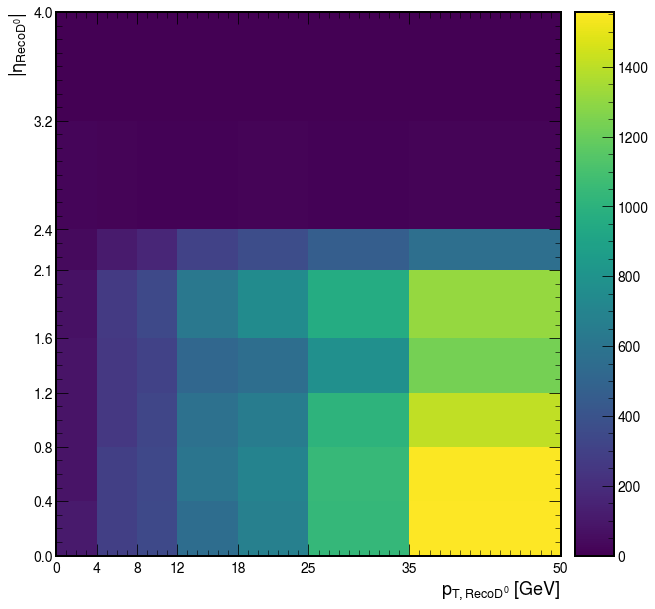

In [22]:
os.system('mkdir -p acceptance_dstar')
os.system('rm -rf acceptance_dstar/*')
os.system('rm -rf /eos/user/k/kmotaama/www/acceptance_dstar')
fig = plt.figure()
for key in output:
    if key == 'details': continue
    os.system(f'mkdir -p acceptance_dstar/{key}')
    for plot in output[key]:
        fig.clear()
        ax = fig.add_subplot()
        if len(output[key][plot].shape) == 1:
            log = False
            if '_pt' in plot: log = True
            create_plot1d(output[key][plot], log=log, ax=ax)
            fig.savefig(f'acceptance_dstar/{key}/{key}_{plot}.png')
        elif len(output[key][plot].shape) == 2:
            create_plot2d(output[key][plot], ax=ax)
            fig.savefig(f'acceptance_dstar/{key}/{key}_{plot}.png')
            if 'Reco' in key:
                make_acceptance_plot(fig, output[key][plot],output[key.replace('Reco', 'Gen')][plot])
                fig.savefig(f'acceptance_dstar/acceptance_{key.removeprefix("Reco_")}.png')



'''fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['ptxmodeta'], output['Gen_Dstar']['ptxmodeta'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{*}}$")
fig.savefig(f'acceptance_dstar/acceptance_dstar_varbins.png')

fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_D0']['ptxeta'], output['Gen_D0']['ptxeta'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{0}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{0}}$")
fig.savefig(f'acceptance_dstar/acceptance_d0.png')

fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_D0']['ptxmodeta'], output['Gen_D0']['ptxmodeta'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{0}}$ [GeV]")
ax.set_ylabel(r"$|\eta_{D^{0}}|$")
fig.savefig(f'acceptance_dstar/acceptance_d0_varbins.png')

os.system(f'cp -r acceptance_dstar /eos/user/k/kmotaama/www/.')'''

In [37]:
import uproot

f = uproot.open(files[0])
events = f['Events'].arrays()

GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMLorentzVector")
        
GenPart_D0 = GenPart[np.absolute(GenPart.pdgId) == 421]
GenPart_Dstar = GenPart[GenPart_D0.genPartIdxMother]

D0 = ak.zip({'mass': events.D0_mass12, **get_vars_dict(events, d0_cols)}, with_name="PtEtaPhiMCandidate")
closer_mass = np.absolute(D0.mass12 - D0_PDG_MASS) < np.absolute(D0.mass21 - D0_PDG_MASS)
D0['mass'] = ak.where(closer_mass, D0.mass12, D0.mass21)
D0 = D0[~D0.hasMuon]

D0 = D0[(D0.mass > 1.8) & (D0.mass < 1.94)]
Dstar = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                'charge': events.Dstar_pischg,
                **get_vars_dict(events, dstar_cols)}, 
                with_name="PtEtaPhiMCandidate")
Dstar = Dstar[~(Dstar.Kchg == Dstar.pichg)]
Dstar = Dstar[~Dstar.hasMuon]
Dstar = Dstar[(Dstar.deltam > 0.14) & (Dstar.deltam < 0.15)]

for i0 in range(len(GenPart_Dstar)):
    print(i0)
    print('GenParticles')
    for i1 in range(len(GenPart_Dstar[i0])):
        print_candidate(GenPart_Dstar[i0][i1])
        print('\t', end='')
        print_candidate(GenPart_D0[i0][i1])
        print('')
    print('Reco')
    for i1 in range(len(Dstar[i0])):
        print(f'Dstar: {build_4mom_string(Dstar[i0][i1])}, D0recIdx: {Dstar.D0recIdx[i0][i1]}, D0dlxy: {Dstar.D0dlxy[i0][i1]:.2f}, D0dlSig: {Dstar.D0dlSig[i0][i1]:.2f}, D0: ({Dstar[i0][i1].D0pt:.2f}, {Dstar[i0][i1].D0eta:.2f}, {Dstar[i0][i1].D0phi:.2f}, {Dstar[i0][i1].D0mass:.2f})')
    for i1 in range(len(D0[i0])):
        print('\t', end='')
        print(f'D0: {build_4mom_string(D0[i0][i1])}, mass12: {D0[i0][i1].mass12:.2f}, mass21: {D0[i0][i1].mass21:.2f}')


0
GenParticles
PDGId: 413, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (90.81, 0.04, -0.91, 2.01)
	PDGId: 421, motherId: 0, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (83.19, 0.04, -0.91, 1.86)

PDGId: -413, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (90.81, -0.04, 2.23, 2.01)
	PDGId: -421, motherId: 1, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (84.22, -0.04, 2.23, 1.86)

Reco
Dstar: (90.20, 0.04, -0.91, 2.00), D0recIdx: 0, D0dlxy: 0.39, D0dlSig: 10.72, D0: (82.83, 0.04, -0.91, 1.86)
Dstar: (91.62, -0.04, 2.23, 2.03), D0recIdx: 1, D0dlxy: 0.94, D0dlSig: 9.64, D0: (84.98, -0.04, 2.23, 1.89)
	D0: (82.83, 0.04, -0.91, 1.86), mass12: 1.98, mass21: 1.86
	D0: (84.98, -0.04, 2.23, 1.86), mass12: 1.86, mass21: 1.89
1
GenParticles
PDGId: 413, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (27.50, 1.35, 2.36, 2.01)
	PDGId: 421, motherId: 0, n_daughters: 2, status: 2, 4

<AxesSubplot:xlabel='$p_{T,D^* Gen}$ [GeV]', ylabel='$\\eta_{D^* Gen}$'>

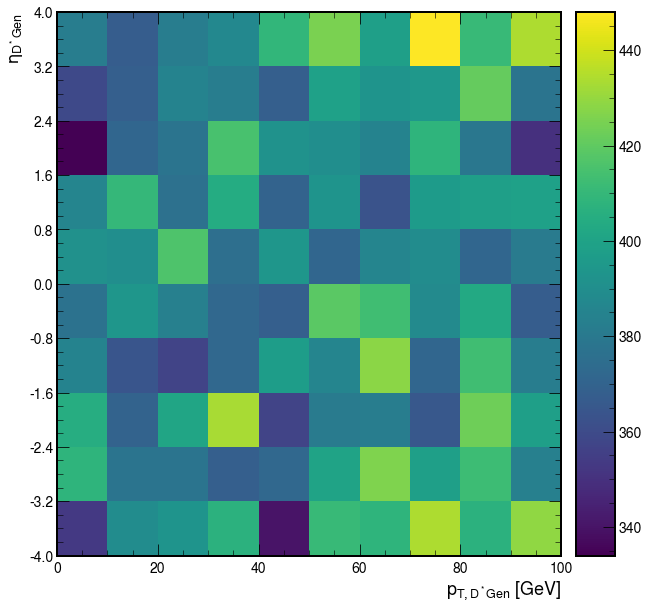

In [10]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()

create_plot2d(output['Gen_Dstar']['Gen_Dstar_ptxeta'], ax=ax)

<AxesSubplot:xlabel='$\\Delta m_{D^* Reco}$ [GeV]'>

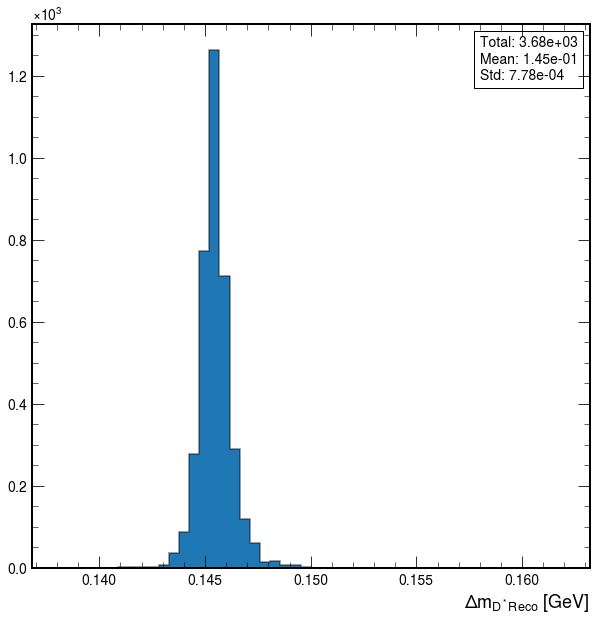

In [41]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()

create_plot1d(output['Reco_Dstar']['Reco_Dstar_deltam'], ax=ax)

/opt/homebrew/Caskroom/miniforge/base/envs/OniaOpenCharmRun2ULenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Text(0, 1, '$\\eta_{D^{*}}$')

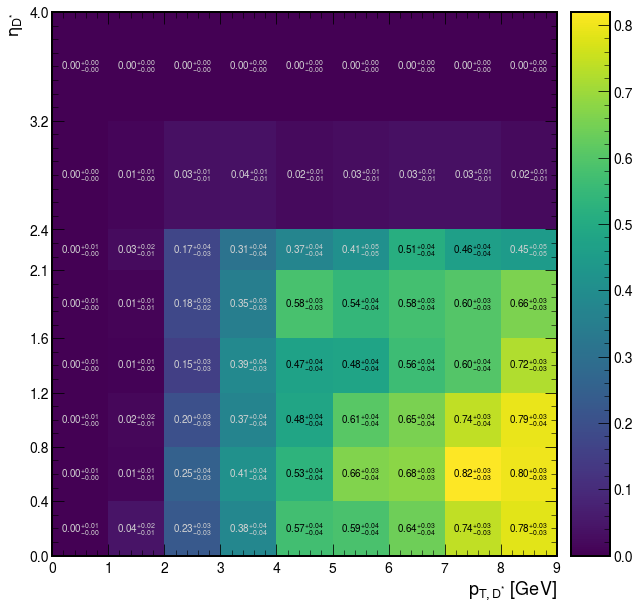

In [12]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['ptxmodeta'], output['Gen_Dstar']['ptxmodeta'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{*}}$")

In [11]:
plt.style.use(mplhep.style.CMS)
    
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})